# Dự đoán nhiệt độ tại Hà Nội bằng Linear Regression

Dự án này sử dụng dữ liệu thời tiết 10 năm tại Hà Nội để xây dựng mô hình hồi quy tuyến tính nhằm dự đoán nhiệt độ. Các bước thực hiện gồm:

1. Tải và xử lý dữ liệu
2. Trích xuất đặc trưng
3. Huấn luyện mô hình
4. Đánh giá hiệu suất
5. Lưu mô hình và kết quả
6. Trực quan hóa kết quả

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

## 1. Tải dữ liệu

Đọc file CSV chứa dữ liệu thời tiết 10 năm tại Hà Nội, hiển thị 5 dòng đầu.

In [9]:
df = pd.read_csv("dataset/Hanoi_temp_10_years.csv")
df.head()

,Unnamed: 0,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,0,Hanoi,2015-01-01,24.0,11.4,17.7,24.0,11.4,17.7,9.4,...,17.1,7,NaN,2015-01-01T06:33:34,2015-01-01T17:26:18,0.36,Clear,Clear conditions throughout the day.,clear-day,"48820099999,48823099999,48825099999,4883109999..."
1,1,Hanoi,2015-01-02,22.0,11.0,16.3,22.0,11.0,16.3,9.4,...,16.2,7,NaN,2015-01-02T06:33:53,2015-01-02T17:26:56,0.39,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"48820099999,48823099999,48825099999,4883109999..."
2,2,Hanoi,2015-01-03,21.0,13.1,17.0,21.0,13.1,17.0,12.4,...,9.9,4,NaN,2015-01-03T06:34:11,2015-01-03T17:27:34,0.43,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"48820099999,48823099999,48825099999,4883109999..."
3,3,Hanoi,2015-01-04,22.6,16.9,19.3,22.6,16.9,19.3,16.1,...,5.6,3,NaN,2015-01-04T06:34:28,2015-01-04T17:28:12,0.46,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"48820099999,48823099999,48825099999,4883109999..."
4,4,Hanoi,2015-01-05,23.0,18.5,20.4,23.0,18.5,20.4,18.4,...,7.9,4,NaN,2015-01-05T06:34:44,2015-01-05T17:28:51,0.50,Overcast,Cloudy skies throughout the day.,cloudy,"48820099999,48823099999,48825099999,4883109999..."


## 2. Trích xuất đặc trưng

Chuyển đổi thời gian và tạo các đặc trưng liên quan đến mùa vụ.

In [10]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['month'] = df['datetime'].dt.month
df['dayofyear'] = df['datetime'].dt.dayofyear
df['sin_doy'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['cos_doy'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

## 3. Chuẩn bị dữ liệu huấn luyện

Chọn các đặc trưng đầu vào và biến mục tiêu.

In [11]:
X = df[['tempmax','tempmin','feelslikemax','feelslikemin','feelslike','dew','humidity',
        'precip','windspeed','windgust','winddir','sealevelpressure','cloudcover',
        'visibility','solarradiation','solarenergy','uvindex','month','dayofyear',
        'sin_doy','cos_doy']]
y = df['temp']

## 4. Huấn luyện mô hình Linear Regression

Chia dữ liệu thành tập huấn luyện và kiểm tra, sau đó huấn luyện mô hình.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## 5. Đánh giá mô hình

Tính các chỉ số R², RMSE và MAE cho cả tập huấn luyện và kiểm tra.

In [13]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

metrics_train = {
    'r2': r2_score(y_train, y_pred_train),
    'rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
    'mae': mean_absolute_error(y_train, y_pred_train)
}
metrics_test = {
    'r2': r2_score(y_test, y_pred_test),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
    'mae': mean_absolute_error(y_test, y_pred_test)
}

print("Train metrics:", metrics_train)
print("Test metrics:", metrics_test)

Train metrics: {'r2': 0.9984075448380587, 'rmse': np.float64(0.20578903213276545), 'mae': 0.15265254370773756}
Test metrics: {'r2': 0.9983167688863661, 'rmse': np.float64(0.20722228883173063), 'mae': 0.15993770507972996}


## 6. Lưu mô hình và kết quả dự đoán

Lưu mô hình đã huấn luyện và kết quả dự đoán vào file.

In [14]:
joblib.dump(model, "weather_lr_model.pkl")

pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
pred_df.to_csv("predictions.csv", index=False)

## 7. Trực quan hóa kết quả dự đoán

Biểu đồ so sánh nhiệt độ thực tế và dự đoán.

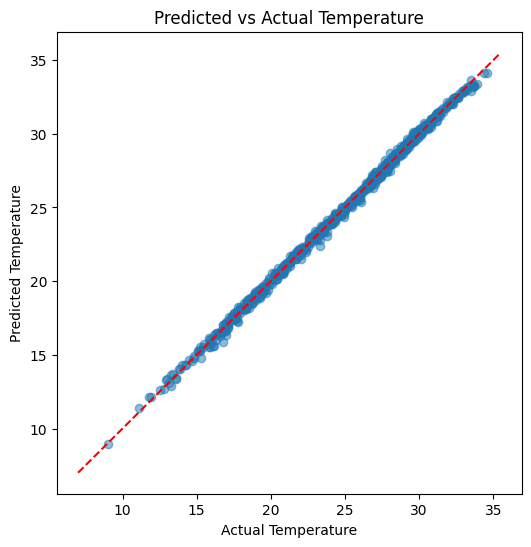

In [15]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.xlabel("Actual Temperature")
plt.ylabel("Predicted Temperature")
plt.title("Predicted vs Actual Temperature")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.savefig("pred_vs_actual.png")
plt.show()